In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.animation import FuncAnimation

%matplotlib inline

In [2]:
# 2D robotic link
'''
    /|--*--*--*
'''

EPS = 1e-2

# robot arm topology
links = np.array([3, 3, 3]).astype(np.float32)
jnts = np.array([[1, 1], [1, 4], [1, 7], [1, 10]]).astype(np.float32)

def rad2degrees(rad):
    return 180.0 * rad / np.pi

def compute_theta(p_next, p_prev):
    delta_p = p_next - p_prev
    return np.arctan2(delta_p[1], delta_p[0])

def fabrik_solve(target, trajectory):
    # check if the target is out of reach
    dist = np.linalg.norm(jnts[0] - target)
    if links.sum() <= dist:
        print('The robot arm is not within reach')
        for idx in range(0, jnts.shape[0] - 1):
            r = np.linalg.norm(target - jnts[idx])
            prop = links[idx] / r
            jnts[idx + 1] =  (1.0 - prop) * jnts[idx] + prop * target
            trajectory.append(np.copy(jnts))
        return np.array(trajectory)
    
    
    print('The robot arm is within reach')
    base = np.copy(jnts[0]) # Note: we do not need a reference
    dist = np.linalg.norm(jnts[-1] - target)
    while dist > EPS:
        # forward
        jnts[-1] = target
        for idx in range(0, jnts.shape[0] - 1):
            idx = jnts.shape[0] - 2 - idx
            r = np.linalg.norm(jnts[idx + 1] - jnts[idx])
            prop = links[idx] / r
            jnts[idx] = (1.0 - prop) * jnts[idx + 1] + prop * jnts[idx]

        # backward
        jnts[0] = base
        for idx in range(0, jnts.shape[0] - 1):
            r = np.linalg.norm(jnts[idx + 1] - jnts[idx])
            prop = links[idx] / r
            jnts[idx + 1] = (1.0 - prop) * jnts[idx] + prop * jnts[idx + 1]
        dist = np.linalg.norm(jnts[-1] - target)
        print(f'\rdist= {dist}', end='')
        
        # Collect trajectory data
        trajectory.append(np.copy(jnts))
    return np.array(trajectory)

class IK:
    @staticmethod
    def solve(target, trajectory, algo='fabrik'):
        if algo == 'fabrik':
            return fabrik_solve(target, trajectory)

The robot arm is within reach
dist= 0.0011065106945241392
Trajectory size: (4, 4, 2)
[[ 1.  1.]
 [ 1.  4.]
 [ 1.  7.]
 [ 1. 10.]]
[[1.        1.       ]
 [0.6583143 3.9804783]
 [2.1440015 6.586766 ]
 [3.8928964 4.149274 ]]
[[1.        1.       ]
 [0.6120888 3.9748151]
 [2.2742457 6.472261 ]
 [3.991407  4.01231  ]]
[[1.         1.        ]
 [0.60851157 3.9743466 ]
 [2.2845533  6.4624953 ]
 [3.9993675  4.000908  ]]

Angles: (3, 3)
[   6.53990613  -29.68485591 -144.34064945]
[ 0.88944772 -3.96060813 -0.74250303]
[ 0.06890295 -0.31913717 -0.05464493]


/home/filip.grigorov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


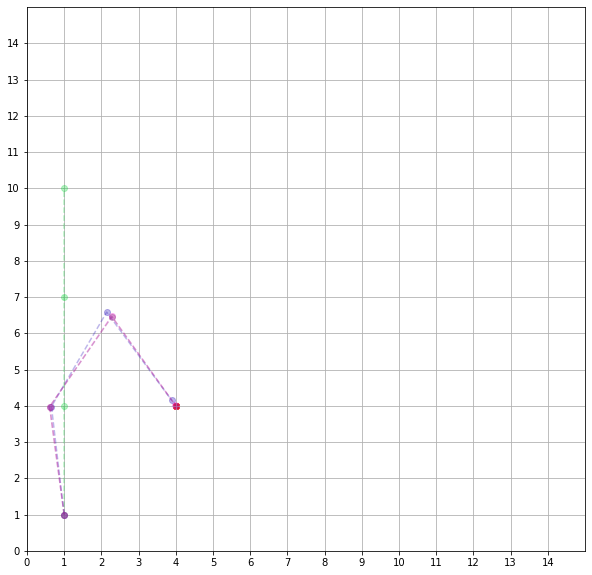

In [3]:
fig = plt.figure(figsize=(10, 10))

plt.grid()
max_x = 15
max_y = 15
plt.xlim(0, max_x)
plt.ylim(0, max_y)
xdim = np.arange(0, max_x, 1)
ydim = np.arange(0, max_y, 1)
plt.xticks(xdim)
plt.yticks(ydim)

# Move the robot arm and solve IK
# (x, y)
trajectory = [ np.copy(jnts) ]
target = np.array([4, 4])
plt.scatter(target[0], target[1], marker='X', c='r')
trajectory = IK.solve(target, trajectory)
print(f'\nTrajectory size: {trajectory.shape}')

for jnts in trajectory:
    print(jnts)
    color = [*np.random.random(3), 0.3]
    plt.plot(jnts[:, 0], jnts[:, 1], marker='o', linestyle='--', color=color)

# forward kinematics
angles = []
base_angle = 90
for idx in range(trajectory.shape[0]):
    jnts = trajectory[idx]
    jnt0 = jnts[0]
    jnt1 = jnts[1]
    jnt2 = jnts[2]
    jnt3 = jnts[3]
    
    djnt0 = jnt1 - jnt0
    djnt1 = jnt2 - jnt1
    djnt2 = jnt3 - jnt2
    
    theta0 = rad2degrees(compute_theta(jnt1, jnt0))
    theta1 = rad2degrees(compute_theta(jnt2, jnt1))
    theta2 = rad2degrees(compute_theta(jnt3, jnt2))
    
    angles.append([theta0, theta1, theta2])

angles = np.array(angles)
    
deltas = []
for idx in range(1, len(angles)):
    deltas.append(angles[idx] - angles[idx - 1])
    
deltas = np.array(deltas)

print(f'\nAngles: {deltas.shape}')
for idx in range(deltas.shape[0]):
    print(deltas[idx])

fig.show()